In [ ]:
!pip install transformers datasets

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

In [ ]:
# Load your cleaned and prepared dataset
df = pd.read_csv('cleaned_reviews.csv')

# Drop any potential rows that might still have missing text
df = df.dropna(subset=['review_text'])

# Display the first few rows to confirm it's loaded correctly
print(df.head())

   review_id  user_id      app_name    app_category  \
0          1  1967825     MX Player  Travel & Local   
1          2  9242600        Tinder      Navigation   
2          3  7636477       Netflix          Dating   
3          4   209031         Venmo    Productivity   
4          5  7190293  Google Drive       Education   

                                         review_text review_language  rating  \
0  Qui doloribus consequuntur. Perspiciatis tempo...              no     1.3   
1  Great app but too many ads, consider premium v...              ru     1.6   
2  The interface could be better but overall good...              es     3.6   
3  Latest update broke some features, please fix ...              vi     3.8   
4  Perfect for daily use, highly recommend to eve...              tl     3.2   

           review_date  verified_purchase     device_type  num_helpful_votes  \
0  2024-10-09 19:26:40               True  Android Tablet                 65   
1  2024-06-21 17:29:40      

In [ ]:
# Convert pandas DataFrame to Hugging Face Dataset object
dataset = Dataset.from_pandas(df)

# Split the dataset into training (80%) and testing (20%) sets
train_test_split_dataset = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split_dataset['train']
test_dataset = train_test_split_dataset['test']

print("Training data shape:", train_dataset.shape)
print("Testing data shape:", test_dataset.shape)

Training data shape: (1934, 16)
Testing data shape: (484, 16)


In [ ]:
# Define the model we are using
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create a function to tokenize the text
def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding="max_length", truncation=True)

# Apply the tokenizer to our datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/1934 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [ ]:
import torch
import gc
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# --- Assuming previous code for loading and tokenizing data is here ---
# tokenized_train_dataset, tokenized_test_dataset, model_name are defined

# Clear CUDA cache to free up unused memory from previous runs
torch.cuda.empty_cache()
gc.collect()

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Define a function to compute metrics during evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Map sentiment labels to integers
sentiment_to_id = {"negative": 0, "neutral": 1, "positive": 2}
def map_sentiment_to_labels(examples):
    examples["labels"] = sentiment_to_id[examples["sentiment"]]
    return examples

# Apply the mapping to create the 'labels' column
tokenized_train_dataset = tokenized_train_dataset.map(map_sentiment_to_labels)
tokenized_test_dataset = tokenized_test_dataset.map(map_sentiment_to_labels)

# Define the training arguments with more aggressive optimizations
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=2,   # <-- FURTHER REDUCED BATCH SIZE
    per_device_eval_batch_size=4,    # <-- FURTHER REDUCED EVAL BATCH SIZE
    gradient_accumulation_steps=8,   # <-- INCREASED ACCUMULATION
    gradient_checkpointing=True,
    fp16=True,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)

# Start the training
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1934 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.045100,1.056317,0.473140,0.303925,0.223862,0.473140
2,1.056800,1.064239,0.473140,0.303925,0.223862,0.473140
3,1.029300,1.068440,0.473140,0.303925,0.223862,0.473140


TrainOutput(global_step=363, training_loss=1.050399336276304, metrics={'train_runtime': 402.8043, 'train_samples_per_second': 14.404, 'train_steps_per_second': 0.901, 'total_flos': 1526584049657856.0, 'train_loss': 1.050399336276304, 'epoch': 3.0})

In [ ]:
# Run the final evaluation on the test dataset
evaluation_results = trainer.evaluate()

# Print the results
print("Evaluation Results:", evaluation_results)

Evaluation Results: {'eval_loss': 1.0563167333602905, 'eval_accuracy': 0.4731404958677686, 'eval_f1': 0.3039247505013156, 'eval_precision': 0.22386192882999792, 'eval_recall': 0.4731404958677686, 'eval_runtime': 6.1179, 'eval_samples_per_second': 79.112, 'eval_steps_per_second': 19.778, 'epoch': 3.0}


In [ ]:
# Get the predictions for the entire test set
predictions = trainer.predict(tokenized_test_dataset)

# The output predictions are logits, so we need to find the class with the highest score
predicted_labels = np.argmax(predictions.predictions, axis=1)

# You can now compare the predicted_labels with the actual labels
# predictions.label_ids contains the true labels

In [ ]:
# Example of a new review to classify
new_review = "This app is absolutely fantastic, I use it every day!"

# Tokenize the new text
inputs = tokenizer(new_review, return_tensors="pt", padding=True, truncation=True)

# Move tensors to the same device as the model (important for GPU)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Get model output (logits)
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted class index
predicted_class_idx = torch.argmax(outputs.logits, dim=1).item()

# You'll need a mapping from index to label name
# Assuming 0: negative, 1: neutral, 2: positive (this depends on your data's encoding)
# Let's create it from the original dataframe
label_mapping = {i: label for i, label in enumerate(df['sentiment'].astype('category').cat.categories)}

print(f"New Review: '{new_review}'")
print(f"Predicted Sentiment: {label_mapping[predicted_class_idx]}")

New Review: 'This app is absolutely fantastic, I use it every day!'
Predicted Sentiment: neutral


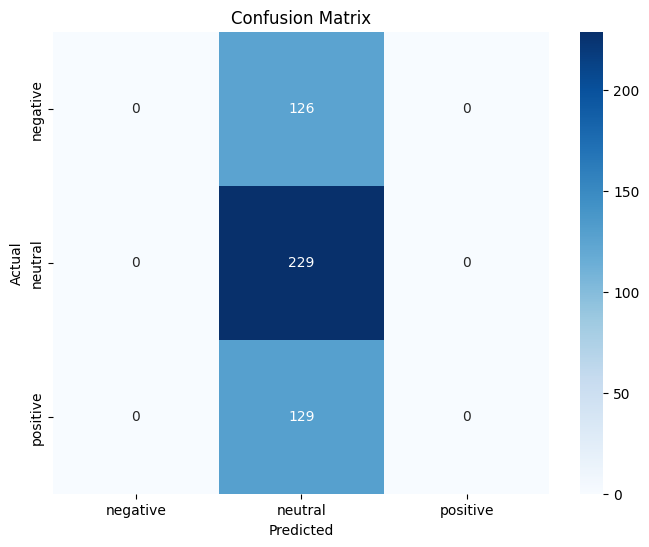

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels from the previous step
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get the class names from our label mapping
class_names = list(label_mapping.values())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()